In [1]:
import numpy as np
import numpy.polynomial.polynomial as n_poly
import numpy.polynomial.legendre as leg
from scipy import integrate
from scipy import optimize
from scipy import interpolate
import sympy as sym
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Set the interval for L2 and the number of basis functions
A=-1.0
B=1.0
N=15

In [3]:
# Define the scalar product in L2([A,B])
t = sym.symbols('t')

def scalar_prod(p0,p1):
    assert len(p0.free_symbols) <= 1, "I can only do this for single variable functions..."
    tt = p0.free_symbols.pop() if len(p0.free_symbols) == 1 else sym.symbols('t')
    foo1 = sym.lambdify(tt, p0, 'numpy')
    foo2 = sym.lambdify(tt, p1, 'numpy')
    foo3 = lambda x : foo1(x) * foo2(x)
    foo = integrate.quad(foo3,A,B)
    return foo[0]

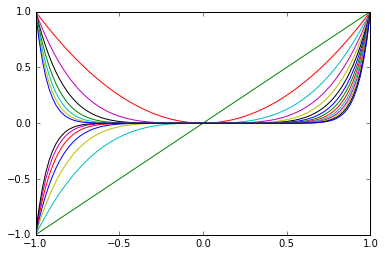

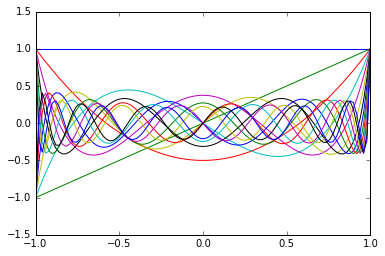

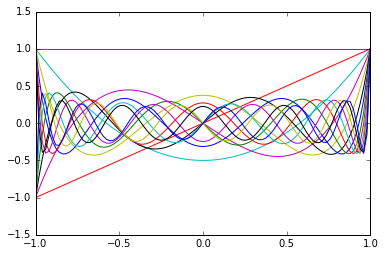

In [4]:


PLk = [1+0.*t] # Force it to be a sympy expression
PMk = [1+0.*t]

for k in range(1,N):
    s = 0
    for j in range(0,k):
        s+= scalar_prod(t**k,PLk[j])/scalar_prod(PLk[j],PLk[j])*PLk[j]
    pk = t**k-s
    # pk = pk/sym.sqrt(scalar_prod(pk,pk))
    pk = pk/pk.subs(t,1.)
    PLk.append(pk)
    PMk.append(t**k)

xx = np.linspace(A,B,100)
figure()
fs = sym.lambdify(t, PMk[0], 'numpy')
plot(xx, np.ones(xx.shape)*fs(xx))
for k in range(1,N):
    fs = sym.lambdify(t, PMk[k], 'numpy')
    plot(xx, fs(xx))
figure()
fs = sym.lambdify(t, PLk[0], 'numpy')
plot(xx, np.ones(xx.shape)*fs(xx))
for k in range(1,N):
    fs = sym.lambdify(t, PLk[k], 'numpy')
    plot(xx, fs(xx))
    

figure()
for k in range(N):
    c = np.zeros(k)
    if k == 0:
        c = 1
    else:
        c[-1] = 1
    plot(xx, leg.legval(xx,c))



29.000029936685976
9385667910.69998


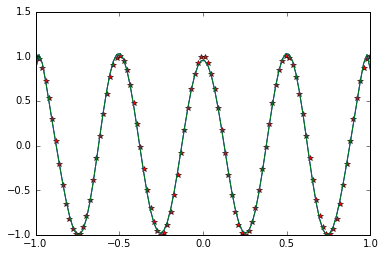

In [5]:
#Best Approximation
f = sym.cos(8.*np.pi/(B-A)*t)

M_LP = np.zeros([N,N])
M_MP = np.zeros([N,N])

f_M = np.zeros([N,1])

f_L = np.zeros([N,1])

for i in range(N):
    f_M[i] = scalar_prod(PMk[i],f)
    f_L[i] = scalar_prod(PLk[i],f)
    for j in range(N):
        M_LP[i,j] = scalar_prod(PLk[i],PLk[j])
        M_MP[i,j] = scalar_prod(PMk[i],PMk[j])

        

p_L = np.linalg.solve(M_LP, f_L)

p_M = np.linalg.solve(M_MP, f_M)
f_p_L = 0.
f_p_M = 0.
for i in range(N):
    f_p_L += p_L[i]*PLk[i]
    f_p_M += p_M[i]*PMk[i]

fpL = sym.lambdify(t, f_p_L[0], 'numpy')
fpM = sym.lambdify(t, f_p_M[0], 'numpy')
ff = sym.lambdify(t, f, 'numpy')

plot(xx, ff(xx), 'r*')
plot(xx, fpL(xx), 'b')
plot(xx, fpL(xx), 'g')

# print M_LP
print(np.linalg.cond(M_LP))
print(np.linalg.cond(M_MP))

[ 9.94521895e-01  9.51056516e-01  8.66025404e-01  7.43144825e-01
  5.87785252e-01  4.06736643e-01  2.07911691e-01  6.12323400e-17
 -2.07911691e-01 -4.06736643e-01 -5.87785252e-01 -7.43144825e-01
 -8.66025404e-01 -9.51056516e-01 -9.94521895e-01]
(2.4000965120782833, 2.6220044621144646e-09)
(0.0035445713701390703, 8.174329886854223e-11)
(0.002946645392217375, 1.0584888361709177e-08)
(0.002001449603045981, 4.0006768887872245e-10)
(0.0020014496030403206, 4.0006546580178886e-10)


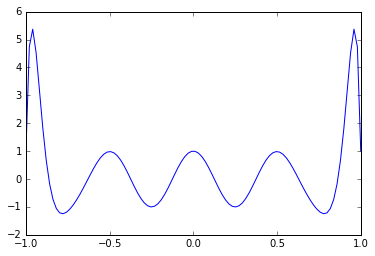

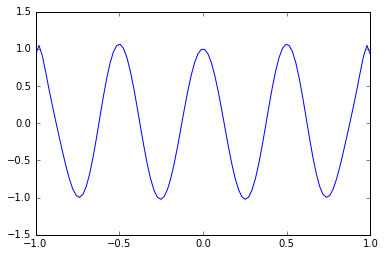

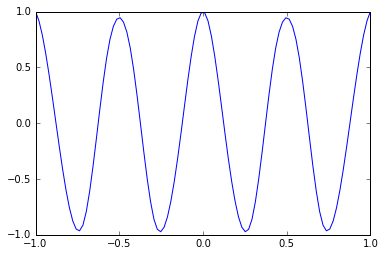

In [9]:
N_lagrange = N
x_interp = np.linspace(A,B,N_lagrange)
x_cheby = np.array([np.cos((2.*j-1)/(2.*N_lagrange)*np.pi) for j in range(1,N_lagrange+1)])
print(x_cheby)
lagrange_interp = interpolate.lagrange(x_interp, ff(x_interp))
cheb_interp = interpolate.lagrange(x_cheby, ff(x_cheby))
tck = interpolate.splrep(x_interp, ff(x_interp), s=0)
yspline = interpolate.splev(xx, tck, der=0)
figure()
plot(xx, lagrange_interp(xx))
figure()
plot(xx, cheb_interp(xx))
figure()
plot(xx, yspline)

print(integrate.quad(lambda x: (ff(x) - lagrange_interp(x))**2,A,B))

print(integrate.quad(lambda x: (ff(x) - cheb_interp(x))**2,A,B))

print(integrate.quad(lambda x: (ff(x) - interpolate.splev(x, tck, der=0))**2,A,B))

print(integrate.quad(lambda x: (ff(x) - fpL(x))**2,A,B))

print(integrate.quad(lambda x: (ff(x) - fpM(x))**2,A,B))

[-0.96028986 -0.96028986 -0.52553241 -0.18343464  0.18343464  0.52553241
  0.96028986  0.96028986]
[-0.96028986 -0.79666648 -0.5255324  -0.18343464  0.18343464  0.52553242
  0.79666648  0.96028986]
[-0.96028986 -0.79666648 -0.52553241 -0.18343464  0.18343464  0.52553241
  0.79666648  0.96028986]
[-0.96028986 -0.79666648 -0.52553241 -0.18343464  0.18343464  0.52553241
  0.79666648  0.96028986]


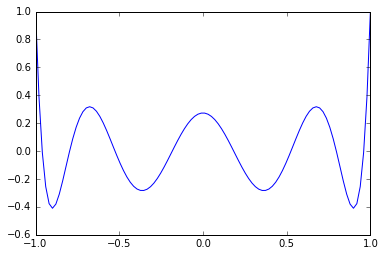

In [13]:
# Root of Legendre polynomial
fs = sym.lambdify(t, PLk[8], 'numpy')
x0 = linspace(A,B,8)
# roots = optimize.brentq(fs, A, B)
roots = optimize.fsolve(fs, x0)
# roots = optimize.root(fs, x0)
print(roots)
plot(xx,fs(xx))
x0[1] = -0.85
x0[-2] = 0.85
roots = optimize.fsolve(fs, x0)
print(roots)

c = np.zeros(8+1)
c[-1] = 1
print(leg.legroots(c))

xg,wg = np.polynomial.legendre.leggauss(8)

print(xg)

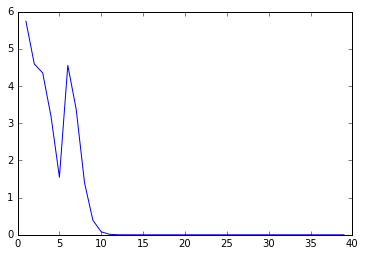

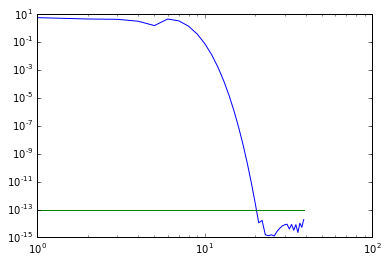

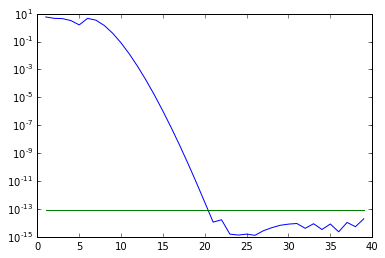

In [14]:
# Gauss Integration

f_gauss = lambda x : 8*np.sin(x)+3*np.cos(15.*x) 

I = integrate.quad(f_gauss,A,B)

n_gauss = 10

xg,wg = np.polynomial.legendre.leggauss(n_gauss)

In = np.dot(wg,f_gauss(xg))

error = list()
Ngmax = 40
order = np.arange(1,Ngmax)
for i in order:
    xg,wg = np.polynomial.legendre.leggauss(i)
#     In = np.dot(wg,f_gauss(xg))
    In = np.einsum('j,j',wg,f_gauss(xg))
    error.append(np.abs(I[0]-In))

# print error
plot(order, error)
figure()
loglog(order,error)
loglog(order,np.ones(Ngmax-1)*I[1])
figure()
semilogy(order, error)
semilogy(order,np.ones(Ngmax-1)*I[1])

## REMARK QUADRATURE ORDER ON (f, vi) FOR BEST APPROXIMATION